In [1]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import animation
import ipywidgets as widgets
from IPython.display import display

# Others
from scipy.special import erf
gaussian_pdf = lambda x, mu=0, s=1: np.exp(-0.5*(x-mu)**2/s**2)/(s*np.sqrt(2*np.pi))
gaussian_cdf = lambda x, mu=0, s=1: 0.5 + 0.5*erf((x-mu)/(s*np.sqrt(2)))


# Nonparametric statistical modeling


**Recap:** Statistical models that do not assume an underlying distribution

Most famous example: **The histogram**

- The histogram is a numerical representation of a distribution 
- The histogram allow us to visualize our data and explore its statistical features
- The histogram is built by dividing the data range in **bins** and counting the observations that fall on a given bin
- The parameters of the histogram are the size and location of the bins

The importance of setting the number of bins right:

interactive(children=(SelectionSlider(description='nbins', index=2, options=(1, 2, 5, 10, 20, 50, 100), value=…

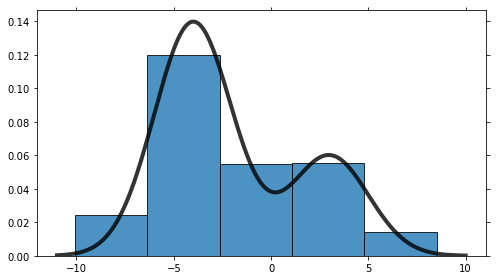

In [2]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
x = np.linspace(-11, 10, num=1000)
px = 0.7*gaussian_pdf(x, mu=-4, s=2) + 0.3*gaussian_pdf(x, mu=3, s=2)
N = 1000; np.random.seed(0)
hatx = np.concatenate((-4 + 2*np.random.randn(int(0.7*N)), 
                       (3 + 2*np.random.randn(int(0.3*N)))))

def update(nbins): 
    ax.cla()
    ax.plot(x, px, 'k-', linewidth=4, alpha=0.8)
    hist, bin_edges = np.histogram(hatx, bins=nbins, density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1:] - bin_edges[:-1], 
           edgecolor='k', align='edge', alpha=0.8)
    
widgets.interact(update, nbins=widgets.SelectionSlider(options=[1, 2, 5, 10, 20, 50, 100], value=5));


- A small number of bins omits the features of the distribution
- A large number of bins introduce noise


## Histogram in practice

How to select the width/number of bins?

- Cross validation
    - AMISE: (Asymptotic) Mean integrated square error
- Rules of thumb, *e.g.* Scott's rule and Silverman's rule
    - Proportional to the scale of data
    - Inversely proportional to the number of samples 
    - Obtained through assumptions


### Silverman's rule

The width of the bins is 

$$
h = 0.9 \frac{\min[\sigma, 0.7412 (q_{75} - q_{25})]}{N^{1/5}},
$$

where $N$ is the number of observations, $\sigma$ is the standard deviation and $q_{75}-q_{25}$ is the interquartile range. 


**Silverman's assumption**: The unknown density is Gaussian


Assuming uniformly spaced bins then the number of bins is

$$
N_{bins} = \frac{\max(x)-\min(x)}{h}
$$


### Other considerations

- Bins could have different boundaries (offsets)
- Bins could have different widths
- Multiresolution approach (wavelet style)


## Kernel density estimation (KDE)

- Other option for non-parametric density estimation is KDE
- In KDE each point has its "own bin", and bins can overlap
- KDE does not require choosing bin boundaries, only bin width

The unidimensional KDE for a set $\{x_i\}_{i=1,\ldots, N}$ is

$$
\hat f_h(x) = \frac{1}{Nh} \sum_{i=1}^N \kappa \left ( \frac{x - x_i}{h} \right)
$$

where $h$ is called the **kernel bandwidth** or kernel size and $\kappa(u)$ is the **kernel function** that need to be positive, zero mean and integrate to unity.

For example, one broadly used kernel is 

$$
\kappa(u) = \frac{1}{\sqrt{2\pi}} \exp \left ( - \frac{u^2}{2} \right),
$$

the Gaussian kernel. 

**Other widely used kernels:** Exponential, Top-hat, Epanechnikov



<center><b>KDE in a nutshell</b>: Place a kernel on top of each point and get the average</center>



**Avoid confusion:** 

- Assuming that the data is **Gaussian distributed** and doing KDE with the **Gaussian kernel** are very **different things**! 
- Using the Gaussian kernel for non-Gaussian data is perfectly fine.



interactive(children=(SelectionSlider(description='$k =h/h_s$', index=3, options=(0.125, 0.25, 0.5, 1, 2, 4), …

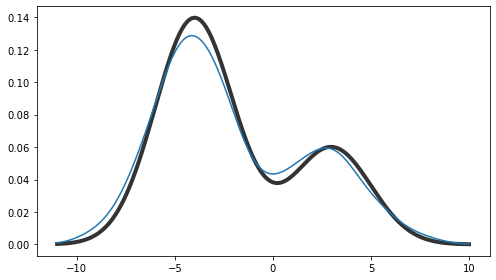

In [3]:
from sklearn.neighbors import KernelDensity
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(x, px, 'k-', linewidth=4, alpha=0.8)
line_kde = ax.plot(x, np.zeros_like(x))
hs = 0.9*np.std(hatx)*N**(-1/5)
def update(k, kernel): 
    kde = KernelDensity(kernel=kernel, bandwidth=hs*k).fit(hatx.reshape(-1, 1))
    line_kde[0].set_ydata(np.exp(kde.score_samples(x.reshape(-1, 1))))
    
widgets.interact(update, k=widgets.SelectionSlider(description="$k =h/h_s$", options=[1/8, 1/4, 1/2, 1, 2, 4], value=1),
        kernel=widgets.SelectionSlider(options=["gaussian", "exponential", "epanechnikov", "tophat"]));

## Other non-parametric methods

- Splines, kernel regression
- Support Vector Machine and Gaussian Processes
- Nearest neighbors

## Non-parametric uncertainty: Bootstrap

The uncertainty of a point-estimate can be non-parametrically calculated using **bootstrap resampling**

In bootstrap you generate new datasets that follow the properties of the original one 

<img src="img/bootstrap_diagram.png">

The conceptual steps are:

1. Create a new set by randomly selecting $N$ observations with replacement
1. Compute the value of your estimator on the new dataset
1. Go back to one until have $T$ values
1. Now you have an empirical distribution for the estimator. Use it to get a confidence interval

**Note:** There are many types of bootstrap tests with different properties and assumptions (more on this in a future class)

interactive(children=(SelectionSlider(description='N', index=1, options=(10, 100, 1000, 10000), value=100), Se…

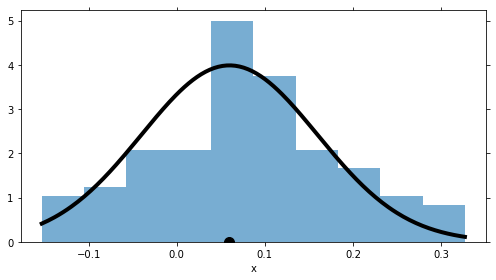

In [4]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)

def update(N, T):
    ax.cla(); ax.set_xlabel('x')
    np.random.seed(0)
    x = np.random.randn(N) # zero mean, unit variance
    mle_mu = np.mean(x)    
    mle_mu_bs = [np.mean(np.random.choice(x, size=len(x), replace=True)) for k in range(T)]
    hist_val, hist_lim, _ = ax.hist(mle_mu_bs, density=True, alpha=0.6)
    t = np.linspace(hist_lim[0], hist_lim[-1], num=200)
    ax.plot(t, gaussian_pdf(t, mu=mle_mu, s=1/np.sqrt(len(x))), 'k-', linewidth=4)  
    ax.scatter(np.mean(x), 0, c='k', s=100, zorder=100)
    display("Empirical confidence interval at 0.95 = [%0.4f, %0.4f]" %(np.sort(mle_mu_bs)[int(0.05*T)], 
                                                                       np.sort(mle_mu_bs)[int(0.95*T)]))    
widgets.interact(update, N=widgets.SelectionSlider(options=[10, 100, 1000, 10000], value=100),
         T=widgets.SelectionSlider(options=[10, 100, 1000, 10000], value=100));